# Prédiction des clients prospects 

In [17]:
### Import
import sys
import csv
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn import preprocessing, neighbors
from sklearn.preprocessing import LabelEncoder

In [50]:
### Load data
df_initial = pd.read_csv('df_new_initial.csv', sep=';')
df_initial.head(20)

,contactid,annee_mois,campagne,campaign,civilite,code_postal,code_postal_naissance,country_connexion_name,csp,date_naissance,...,patrimoine,pays,pays_naissance,regime_matrimonial,revenus_annuels,service,timestamp,id_dim_personne,encours,cible
0,6546762003,NaN,-1.0,Source URL non trouvée,NaN,NaN,59430.0,France,15.0,NaN,...,-1.0,NaN,FRA,2.0,2.0,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-09-21T01:28:13.601+0200,6546762003,5.00,0
1,6742433330,NaN,456.0,REC_Liens textes autopromotion 456,0,31130.0,38000.0,France,2.0,11/04/1969,...,2.0,FRA,FRA,4.0,2.0,SFOL_AJOUTER_CB,2016-10-31T18:16:38.719+0100,6742433330,0.00,0
2,6856828837,201611.0,868.0,PAR_Onlin_Site _ECard,MR,92000.0,92150.0,France,2.0,11/05/1957,...,2.0,FRA,FRA,2.0,4.0,monprofil.PROSPECT/CREER_FICHE_PROSPECT,2016-11-21T12:01:44.736+0100,6856828837,8899.93,1
3,6754882186,NaN,300.0,Intb_Banque_Autre,1,94800.0,93420.0,France,2.0,24/06/1988,...,0.0,FRA,FRA,2.0,2.0,SFOL_AJOUTER_CB,2016-11-04T10:46:58.447+0100,6754882186,10.00,0
4,6289817192,201611.0,300.0,Intb_Banque_Autre,MR,26170.0,84600.0,Switzerland,2.0,01/05/1994,...,0.0,FRA,FRA,0.0,2.0,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-11-21T17:36:53.976+0100,6289817192,173.53,0
5,6748699778,NaN,307.0,REC_Onlin_MC_Googl,0,73150.0,92290.0,France,2.0,28/10/1962,...,3.0,FRA,FRA,2.0,2.0,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-11-01T13:44:10.556+0100,6748699778,10.00,0
6,6856855432,201612.0,307.0,REC_Onlin_MC_Googl,MR,75015.0,75015.0,France,18.0,08/10/1992,...,0.0,FRA,FRA,0.0,1.0,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-12-13T19:17:18.159+0100,6856855432,234.08,0
7,6821231675,201611.0,868.0,PAR_Onlin_Site _ECard,2,69001.0,69008.0,France,3.0,07/08/1989,...,0.0,FRA,FRA,0.0,1.0,SFOL_AJOUTER_CB,2016-11-15T16:46:02.913+0100,6821231675,3442.00,1
8,6747566365,NaN,868.0,PAR_Onlin_Site _ECard,2,75015.0,42000.0,France,2.0,09/06/1988,...,0.0,FRA,FRA,0.0,2.0,SFOL_AJOUTER_CB,2016-11-01T10:11:34.523+0100,6747566365,380.00,0
9,6888675097,201611.0,1543.0,REC_Onlin_Parte_Bours_SP,MLE,59161.0,59300.0,France,12.0,13/06/1996,...,0.0,FRA,FRA,0.0,0.0,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-11-26T17:13:18.006+0100,6888675097,319.63,0


# DF sans parrain

In [51]:
### Data management
def data_management(df):
    
    ### Fill empty value
    
    df['code_postal'] = df['code_postal'].replace('',-2)
    df['code_postal'] = pd.to_numeric(df['code_postal'])
    
    df['code_postal_naissance'] = pd.to_numeric(df['code_postal_naissance'])
   
    df['country_connexion_name'] = df['country_connexion_name'].replace(['',None],-2)
    
    df['date_naissance'] = df['date_naissance'].replace('','01/01/1800')
    
    df['flag_epargne'] = pd.to_numeric(df['flag_epargne'])
    
    #df['mailing_accord'] = df['mailing_accord'].replace(['',None],-2)
    #df['mailing_accord'] = pd.to_numeric(df['mailing_accord'])
    del df['mailing_accord']
    
    df['nature_cb'] = df['nature_cb'].replace(['',None],-2)
    df['nature_cb'] = pd.to_numeric(df['nature_cb'])
    
    df['pays_naissance'] = df['pays_naissance'].replace(['',None],-2)
    
    ### get age
    get_age(df)

    ### Get flag parrain from namesponsor
    df['Parrain'] = df['namesponsor'].map(lambda x: 0 if pd.isnull(x) else 1).astype(int)
    del df['firstnamesponsor'] 
    del df['namesponsor'] 
    
    ### Get domain from mail
    df['mail'] = df.mail.replace ([np.nan], '')
    df['domain'] = df['mail'].map(lambda x: x.split("@")[1] if x else None)
    df['domain'] = df.domain.str.lower()
    del df['mail']

    ### Get Sex from Civility
    df['Sex'] = df['civilite'].map(get_sex)
    del df['civilite']
    
    ### Delete useless cols
    del df['annee_mois']
    del df['id_dim_temps']
    del df['id_dim_personne']
    del df['encours']
    del df['timestamp']
    del df['service']
    del df['campaign']
    del df['contactid']
    del df['pays']
    
    ### transform to numeric when possible
    df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    df['country_connexion_name'] = df['country_connexion_name'].replace ([np.nan], '')
    df['domain'] = df['domain'].replace ([np.nan], '')
    df['pays_naissance'] = df['pays_naissance'].replace ([np.nan], '')
    df.loc[df['country_connexion_name'].value_counts()[df['country_connexion_name']].values < 40, 'country_connexion_name'] = 'other'
    df.loc[df['domain'].value_counts()[df['domain']].values < 40, 'domain'] = 'other'
    df.loc[df['pays_naissance'].value_counts()[df['pays_naissance']].values < 40, 'pays_naissance'] = 'other'
    
    
    ### Get country connexion name
    df['country_connexion'] = df['country_connexion_name'].map(process_country_connexion)
    del df['country_connexion_name']
    ### Get pays de naissance
    df['pays_de_naissance'] = df['pays_naissance'].map(process_pays_naissance)
    del df['pays_naissance']
    
    ### Process the domain
    df = process_domain (df)
    
    ### Drop NaN 
    df = df.dropna()
    
    features_df = df.drop('cible', axis=1)
    target = df['cible']
    return features_df, target, df


def get_sex(x):
    if x == "0":
        return 1
    elif (x == "1"):
        return 0
    elif (x == "2"):
        return 0
    elif (x == "MR"):
        return 1
    elif (x == "MLE"):
        return 0
    elif (x == "MME"):
        return 0
    else :
        return -1

def get_age(X):
    from datetime import datetime
    now = datetime.now()
    X['AGE'] = X['date_naissance'].dropna()
    X['AGE'] = pd.to_datetime(X['AGE'],errors='coerce')
    X['AGE'] = X['AGE'].map(lambda x : now.year-x.year  if now.month-x.month>0 else now.year - x.year -1 )
    del X['date_naissance']
    
def process_country_connexion(x):
    
    if x == 'France':
        return 1
    elif (x == 'United Kingdom'):
        return 2
    elif (x == 'other'):
        return 3
    elif (x == 'Germany'):
        return 4
    elif (x == 'Switzerland'):
        return 5
    elif (x == 'Netherlands'):
        return 6
    elif (x == 'Europe'):
        return 7
    elif (x == 'United States'):
        return 8
    elif (x == 'Reunion'):
        return 9
    elif (x==-2):
        return -2
    
def process_pays_naissance(x):

    if x == 'FRA':
        return 1
    elif (x == 'ITA'):
        return 2
    elif (x == 'other'):
        return 3
    elif (x == 'DZA'):
        return 4
    elif (x == 'BEN'):
        return 5
    elif (x == 'ESP'):
        return 6
    elif (x == 'VNM'):
        return 7
    elif (x == 'DEU'):
        return 8
    elif (x == 'MAR'):
        return 9
    elif (x=='CIV'):
        return 10
    elif (x=='CMR'):
        return 10
    elif (x=='GTO'):
        return 11
    elif (x=='SEN'):
        return 12
    elif (x=='BEL'):
        return 13
    elif (x=='CHN'):
        return 14
    elif (x=='ROU'):
        return 15
    elif (x=='BRA'):
        return 16
    elif (x=='MDG'):
        return 17
    elif (x=='PRT'):
        return 18
    elif (x=='GBR'):
        return 19
    elif (x=='LBN'):
        return 20
    elif (x=='TUR'):
        return 21
    elif (x=='IND'):
        return 22
    
def process_domain(x):
    """
    Process the domain features
    """
    dict_ = {'yahoo.fr':0, 'hotmail.fr':1, 'hotmail.com': 2, 'gmail.com': 3, 'orange.fr': 4, 'outlook.com': 5, 'free.fr': 6, 'laposte.net': 7, 'other': 8, 'neuf.fr': 9, 'wanadoo.fr': 10, 'me.com': 11, 'ymail.com': 12, 'sfr.fr': 13, 'live.fr': 14, 'bbox.fr': 15, 'outlook.fr': 16, 'msn.com': 17, 'yahoo.com': 18, 'aol.com': 19, 'icloud.com': 20, 'cegetel.net': 21, 'club-internet.fr': 22}
    x['domain'] = x['domain'].map(dict_)
    return x

In [52]:
X, y, data  = data_management(df_initial)

In [53]:
data.mailing

,campagne,code_postal,code_postal_naissance,csp,debit_cb,flag_banque_principale,flag_epargne,nature_cb,patrimoine,regime_matrimonial,revenus_annuels,cible,AGE,Parrain,domain,Sex,country_connexion,pays_de_naissance
1,456.0,31130.0,38000.0,2.0,0.0,0.0,0,1.0,2.0,4.0,2.0,0,47.0,0,0.0,1,1.0,1.0
3,300.0,94800.0,93420.0,2.0,0.0,0.0,0,1.0,0.0,2.0,2.0,0,28.0,0,1.0,0,1.0,1.0
5,307.0,73150.0,92290.0,2.0,0.0,0.0,0,1.0,3.0,2.0,2.0,0,54.0,0,2.0,1,1.0,1.0
7,868.0,69001.0,69008.0,3.0,2.0,1.0,0,0.0,0.0,0.0,1.0,1,27.0,1,3.0,0,1.0,1.0
8,868.0,75015.0,42000.0,2.0,0.0,0.0,1,1.0,0.0,0.0,2.0,0,28.0,1,3.0,0,1.0,1.0
17,1849.0,72550.0,72000.0,4.0,0.0,0.0,0,1.0,1.0,6.0,2.0,0,29.0,0,3.0,-1,1.0,1.0
22,868.0,44130.0,64000.0,15.0,2.0,1.0,1,0.0,0.0,0.0,1.0,1,32.0,0,3.0,1,1.0,1.0
26,868.0,95210.0,95100.0,4.0,1.0,1.0,0,0.0,0.0,2.0,1.0,0,29.0,1,3.0,1,1.0,1.0
38,868.0,35510.0,62000.0,2.0,0.0,0.0,0,1.0,3.0,2.0,3.0,0,47.0,0,4.0,0,1.0,1.0
43,868.0,92190.0,92290.0,2.0,0.0,0.0,0,1.0,1.0,0.0,2.0,0,31.0,1,0.0,0,1.0,1.0


In [54]:
data.dtypes

campagne                  float64
code_postal               float64
code_postal_naissance     float64
csp                       float64
debit_cb                  float64
flag_banque_principale    float64
flag_epargne                int64
nature_cb                 float64
patrimoine                float64
regime_matrimonial        float64
revenus_annuels           float64
cible                       int64
AGE                       float64
Parrain                     int32
domain                    float64
Sex                         int64
country_connexion         float64
pays_de_naissance         float64
dtype: object

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9150, 17)
(1017, 17)
(9150,)
(1017,)


In [56]:
### Modèle 1 : RDF
classifier= RandomForestClassifier(n_estimators=200,max_depth=201)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print ('accuracy score : '+ str(accuracy_score(y_test, y_pred)))
print('\n classification_report:\n', classification_report(y_test, y_pred))
print ('\n confussion matrix:\n', confusion_matrix(y_test, y_pred))

accuracy score : 0.771878072763

 classification_report:
              precision    recall  f1-score   support

          0       0.79      0.97      0.87       792
          1       0.41      0.08      0.13       225

avg / total       0.70      0.77      0.70      1017


 confussion matrix:
 [[768  24]
 [208  17]]


In [57]:
                     ######################## Testing with balanced labels #########################
#Running Easy Ensemble
import imblearn.ensemble as ensemble
EE = ensemble.EasyEnsemble()
print(X_train.shape)
ancien_y = pd.DataFrame(y_train, columns=["cible"])
print("Ancien: ", ancien_y[(ancien_y["cible"] == 1)].shape[0], "positives ", 
      ancien_y[(ancien_y["cible"] == 0)].shape[0], "negatives")
sets_X, sets_y = EE.fit_sample(X_train.as_matrix(), y_train.as_matrix())
balanced_X = np.array(sets_X).reshape(-1, X_train.shape[1])
balanced_y = np.array(sets_y).reshape(-1, 1)
print(balanced_X.shape)
# Create temporary DataFrame
featureNames =["campagne","code_postal", "code_postal_naissance", "csp", "debit_cb", "flag_banque_principale", "flag_epargne", "nature_cb", "patrimoine", "regime_matrimonial", "revenus_annuels", "AGE", "Parrain", "domain", "Sex", "country_connexion", "pays_de_naissance"]
X_train_temp = pd.DataFrame(balanced_X, columns=featureNames)
temp_y = pd.DataFrame(balanced_y, columns=["cible"])
y_train_temp = temp_y["cible"]
print("Original: ", temp_y[(temp_y["cible"] == 1)].shape[0], "positives ", 
      temp_y[(temp_y["cible"] == 0)].shape[0], "negatives")

(9150, 17)
Ancien:  1872 positives  7278 negatives
(37440, 17)
Original:  18720 positives  18720 negatives


In [60]:
# Modèle 1 : RDF
forest_b= RandomForestClassifier(n_estimators=200,max_depth=201)
forest_b.fit(X_train_temp, y_train_temp)
y_pred_b = forest_b.predict(X_test)
print ('accuracy score : '+ str(accuracy_score(y_test, y_pred_b)))
print('\n classification_report:\n', classification_report(y_test, y_pred_b))
print ('\n confussion matrix:\n', confusion_matrix(y_test, y_pred_b))

accuracy score : 0.767944936087

 classification_report:
              precision    recall  f1-score   support

          0       0.80      0.94      0.86       792
          1       0.43      0.15      0.22       225

avg / total       0.71      0.77      0.72      1017


 confussion matrix:
 [[748  44]
 [192  33]]


In [63]:
# Modèle 2: MLP
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(hidden_layer_sizes=(13, 24), random_state=50)
clf_mlp.fit(X_train_temp, y_train_temp)
y2_pred = clf_mlp.predict(X_test)

print(classification_report(y_test, y2_pred))
print ('accuracy score : '+ str(accuracy_score(y_test, y2_pred)))
print ('\n confussion matrix:\n',confusion_matrix(y_test, y2_pred))

             precision    recall  f1-score   support

          0       0.78      0.97      0.87       792
          1       0.27      0.04      0.06       225

avg / total       0.67      0.76      0.69      1017

accuracy score : 0.764995083579

 confussion matrix:
 [[770  22]
 [217   8]]


# Multiclass sans parrain

In [66]:
df_multi = pd.read_csv('df_new_initial.csv', sep=';')
df_multi.head(5)

,contactid,annee_mois,campagne,campaign,civilite,code_postal,code_postal_naissance,country_connexion_name,csp,date_naissance,...,patrimoine,pays,pays_naissance,regime_matrimonial,revenus_annuels,service,timestamp,id_dim_personne,encours,cible
0,6546762003,NaN,-1.0,Source URL non trouvée,NaN,NaN,59430.0,France,15.0,NaN,...,-1.0,NaN,FRA,2.0,2.0,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-09-21T01:28:13.601+0200,6546762003,5.00,0
1,6742433330,NaN,456.0,REC_Liens textes autopromotion 456,0,31130.0,38000.0,France,2.0,11/04/1969,...,2.0,FRA,FRA,4.0,2.0,SFOL_AJOUTER_CB,2016-10-31T18:16:38.719+0100,6742433330,0.00,0
2,6856828837,201611.0,868.0,PAR_Onlin_Site _ECard,MR,92000.0,92150.0,France,2.0,11/05/1957,...,2.0,FRA,FRA,2.0,4.0,monprofil.PROSPECT/CREER_FICHE_PROSPECT,2016-11-21T12:01:44.736+0100,6856828837,8899.93,1
3,6754882186,NaN,300.0,Intb_Banque_Autre,1,94800.0,93420.0,France,2.0,24/06/1988,...,0.0,FRA,FRA,2.0,2.0,SFOL_AJOUTER_CB,2016-11-04T10:46:58.447+0100,6754882186,10.00,0
4,6289817192,201611.0,300.0,Intb_Banque_Autre,MR,26170.0,84600.0,Switzerland,2.0,01/05/1994,...,0.0,FRA,FRA,0.0,2.0,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-11-21T17:36:53.976+0100,6289817192,173.53,0


In [67]:
## Change binary label into multiclass 
df_multi['cible'] = pd.qcut(df_multi['encours'].values, 5).codes
df_multi['cible'].unique()

array([0, 4, 1, 2, 3], dtype=int64)

In [68]:
### Data management
def data_management(df):
    
    ### Fill empty value
    
    df['code_postal'] = df['code_postal'].replace('',-2)
    df['code_postal'] = pd.to_numeric(df['code_postal'])
    
    df['code_postal_naissance'] = pd.to_numeric(df['code_postal_naissance'])
   
    df['country_connexion_name'] = df['country_connexion_name'].replace(['',None],-2)
    
    df['date_naissance'] = df['date_naissance'].replace('','01/01/1800')
    
    df['flag_epargne'] = pd.to_numeric(df['flag_epargne'])
    
    #df['mailing_accord'] = df['mailing_accord'].replace(['',None],-2)
    #df['mailing_accord'] = pd.to_numeric(df['mailing_accord'])
    del df['mailing_accord']
    
    df['nature_cb'] = df['nature_cb'].replace(['',None],-2)
    df['nature_cb'] = pd.to_numeric(df['nature_cb'])
    
    df['pays_naissance'] = df['pays_naissance'].replace(['',None],-2)
    
    ### get age
    get_age(df)

    ### Get flag parrain from namesponsor
    df['Parrain'] = df['namesponsor'].map(lambda x: 0 if pd.isnull(x) else 1).astype(int)
    del df['firstnamesponsor'] 
    del df['namesponsor'] 
    
    ### Get domain from mail
    df['mail'] = df.mail.replace ([np.nan], '')
    df['domain'] = df['mail'].map(lambda x: x.split("@")[1] if x else None)
    df['domain'] = df.domain.str.lower()
    del df['mail']

    ### Get Sex from Civility
    df['Sex'] = df['civilite'].map(get_sex)
    del df['civilite']
    
    ### Delete useless cols
    del df['annee_mois']
    del df['id_dim_temps']
    del df['id_dim_personne']
    del df['encours']
    del df['timestamp']
    del df['service']
    del df['campaign']
    del df['contactid']
    del df['pays']
    
    ### transform to numeric when possible
    df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    df['country_connexion_name'] = df['country_connexion_name'].replace ([np.nan], '')
    df['domain'] = df['domain'].replace ([np.nan], '')
    df['pays_naissance'] = df['pays_naissance'].replace ([np.nan], '')
    df.loc[df['country_connexion_name'].value_counts()[df['country_connexion_name']].values < 40, 'country_connexion_name'] = 'other'
    df.loc[df['domain'].value_counts()[df['domain']].values < 40, 'domain'] = 'other'
    df.loc[df['pays_naissance'].value_counts()[df['pays_naissance']].values < 40, 'pays_naissance'] = 'other'
    
    
    ### Get country connexion name
    df['country_connexion'] = df['country_connexion_name'].map(process_country_connexion)
    del df['country_connexion_name']
    ### Get pays de naissance
    df['pays_de_naissance'] = df['pays_naissance'].map(process_pays_naissance)
    del df['pays_naissance']
    
    ### Process the domain
    df = process_domain (df)
    
    ### Drop NaN 
    df = df.dropna()
    
    features_df = df.drop('cible', axis=1)
    target = df['cible']
    return features_df, target, df


def get_sex(x):
    if x == "0":
        return 1
    elif (x == "1"):
        return 0
    elif (x == "2"):
        return 0
    elif (x == "MR"):
        return 1
    elif (x == "MLE"):
        return 0
    elif (x == "MME"):
        return 0
    else :
        return -1

def get_age(X):
    from datetime import datetime
    now = datetime.now()
    X['AGE'] = X['date_naissance'].dropna()
    X['AGE'] = pd.to_datetime(X['AGE'],errors='coerce')
    X['AGE'] = X['AGE'].map(lambda x : now.year-x.year  if now.month-x.month>0 else now.year - x.year -1 )
    del X['date_naissance']
    
def process_country_connexion(x):
    
    if x == 'France':
        return 1
    elif (x == 'United Kingdom'):
        return 2
    elif (x == 'other'):
        return 3
    elif (x == 'Germany'):
        return 4
    elif (x == 'Switzerland'):
        return 5
    elif (x == 'Netherlands'):
        return 6
    elif (x == 'Europe'):
        return 7
    elif (x == 'United States'):
        return 8
    elif (x == 'Reunion'):
        return 9
    elif (x==-2):
        return -2
    
def process_pays_naissance(x):

    if x == 'FRA':
        return 1
    elif (x == 'ITA'):
        return 2
    elif (x == 'other'):
        return 3
    elif (x == 'DZA'):
        return 4
    elif (x == 'BEN'):
        return 5
    elif (x == 'ESP'):
        return 6
    elif (x == 'VNM'):
        return 7
    elif (x == 'DEU'):
        return 8
    elif (x == 'MAR'):
        return 9
    elif (x=='CIV'):
        return 10
    elif (x=='CMR'):
        return 10
    elif (x=='GTO'):
        return 11
    elif (x=='SEN'):
        return 12
    elif (x=='BEL'):
        return 13
    elif (x=='CHN'):
        return 14
    elif (x=='ROU'):
        return 15
    elif (x=='BRA'):
        return 16
    elif (x=='MDG'):
        return 17
    elif (x=='PRT'):
        return 18
    elif (x=='GBR'):
        return 19
    elif (x=='LBN'):
        return 20
    elif (x=='TUR'):
        return 21
    elif (x=='IND'):
        return 22
    
def process_domain(x):
    """
    Process the domain features
    """
    dict_ = {'yahoo.fr':0, 'hotmail.fr':1, 'hotmail.com': 2, 'gmail.com': 3, 'orange.fr': 4, 'outlook.com': 5, 'free.fr': 6, 'laposte.net': 7, 'other': 8, 'neuf.fr': 9, 'wanadoo.fr': 10, 'me.com': 11, 'ymail.com': 12, 'sfr.fr': 13, 'live.fr': 14, 'bbox.fr': 15, 'outlook.fr': 16, 'msn.com': 17, 'yahoo.com': 18, 'aol.com': 19, 'icloud.com': 20, 'cegetel.net': 21, 'club-internet.fr': 22}
    x['domain'] = x['domain'].map(dict_)
    return x

In [69]:
X_multi, y_multi, data_multi = data_management(df_multi)

In [70]:
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split (X_multi,y_multi,random_state=42)

In [75]:
# RDF
classifier_forest= RandomForestClassifier(n_estimators=200,max_depth=201)
classifier_forest.fit(X_multi_train, y_multi_train)
y_multi_pred = classifier_forest.predict(X_multi_test)
print ('accuracy score : '+ str(accuracy_score(y_multi_test, y_multi_pred)))
print(classification_report(y_multi_test, y_multi_pred))
print ('confussion matrix:' , confusion_matrix(y_multi_test, y_multi_pred))

accuracy score : 0.299370574351
             precision    recall  f1-score   support

          0       0.33      0.35      0.34       452
          1       0.29      0.24      0.26       523
          2       0.30      0.33      0.31       528
          3       0.22      0.17      0.20       516
          4       0.33      0.41      0.36       523

avg / total       0.29      0.30      0.29      2542

confussion matrix: [[159  68  80  74  71]
 [106 124 115  76 102]
 [ 61  90 172  74 131]
 [ 73  87 123  90 143]
 [ 80  61  78  88 216]]


In [83]:
# MLP
from sklearn.neural_network import MLPClassifier
clf1_mlp = MLPClassifier(hidden_layer_sizes=(13, 16), random_state=50)
clf1_mlp.fit(X_multi_train, y_multi_train)
y3_multi_pred = clf1_mlp.predict(X_multi_test)
print(classification_report(y_multi_test, y3_multi_pred))
print ('accuracy score : '+ str(accuracy_score(y_multi_test, y3_multi_pred)))
print ('confussion matrix: ' , confusion_matrix(y_multi_test, y3_multi_pred))

             precision    recall  f1-score   support

          0       0.20      0.23      0.22       452
          1       0.24      0.09      0.13       523
          2       0.33      0.01      0.02       528
          3       0.21      0.72      0.32       516
          4       0.12      0.00      0.01       523

avg / total       0.22      0.21      0.14      2542

accuracy score : 0.208497246263
confussion matrix:  [[106  25   3 314   4]
 [104  47   1 364   7]
 [110  36   5 376   1]
 [ 99  40   5 370   2]
 [105  46   1 369   2]]


In [87]:
   ######################## Testing with balanced labels #########################
# Running Easy Ensemble
import imblearn.ensemble as ensemble
EE_multi = ensemble.EasyEnsemble()
print(X_multi_train.shape)
ancien_multi_y = pd.DataFrame(y_multi_train, columns=["cible"])
print("Ancien: ", ancien_multi_y[(ancien_multi_y["cible"] == 1)].shape[0], "positives ", 
      ancien_multi_y[(ancien_multi_y["cible"] == 0)].shape[0], "negatives")
sets_multi_X, sets_multi_y = EE_multi.fit_sample(X_multi_train.as_matrix(), y_multi_train.as_matrix())
balanced_multi_X = np.array(sets_multi_X).reshape(-1, X_multi_train.shape[1])
balanced_multi_y = np.array(sets_multi_y).reshape(-1, 1)
print(balanced_multi_X.shape)
# Create temporary DataFrame
featureNames_multi =["campagne","code_postal", "code_postal_naissance", "csp", "debit_cb", "flag_banque_principale", "flag_epargne", "nature_cb", "patrimoine", "regime_matrimonial", "revenus_annuels", "AGE", "Parrain", "domain", "Sex", "country_connexion", "pays_de_naissance"]
X_multi_train_temp = pd.DataFrame(balanced_multi_X, columns=featureNames)
temp_multi_y = pd.DataFrame(balanced_multi_y, columns=["cible"])
y_multi_train_temp = temp_multi_y["cible"]
print("Original: ", temp_multi_y[(temp_multi_y["cible"] == 1)].shape[0], "positives ", 
      temp_multi_y[(temp_multi_y["cible"] == 0)].shape[0], "negatives")

(7625, 17)
Ancien:  1497 positives  1441 negatives
(72050, 17)
Original:  14410 positives  14410 negatives


In [89]:
# RDF
class_forest= RandomForestClassifier(n_estimators=200,max_depth=201)
class_forest.fit(X_multi_train_temp, y_multi_train_temp)
y_multi_pred_temp = class_forest.predict(X_multi_test)
print ('accuracy score : '+ str(accuracy_score(y_multi_test, y_multi_pred_temp)))
print(classification_report(y_multi_test, y_multi_pred))
print ('confussion matrix:' , confusion_matrix(y_multi_test, y_multi_pred_temp))

accuracy score : 0.280487804878
             precision    recall  f1-score   support

          0       0.33      0.35      0.34       452
          1       0.29      0.24      0.26       523
          2       0.30      0.33      0.31       528
          3       0.22      0.17      0.20       516
          4       0.33      0.41      0.36       523

avg / total       0.29      0.30      0.29      2542

confussion matrix: [[141  83  76  78  74]
 [105 116 118  80 104]
 [ 69  87 163  83 126]
 [ 74  95 110 101 136]
 [ 74  68  82 107 192]]


# Avec parrain

In [108]:
df_init_p = pd.read_csv('df_new_initial.csv', sep=';') 
df_init_p.head(5)

,contactid,annee_mois,campagne,campaign,civilite,code_postal,code_postal_naissance,country_connexion_name,csp,date_naissance,...,patrimoine,pays,pays_naissance,regime_matrimonial,revenus_annuels,service,timestamp,id_dim_personne,encours,cible
0,6546762003,nan,-1,Source URL non trouvée,NaN,nan,59430,France,15,NaN,...,-1,NaN,FRA,2,2,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-09-21T01:28:13.601+0200,6546762003,5,0
1,6742433330,nan,456,REC_Liens textes autopromotion 456,0,31130,38000,France,2,11/04/1969,...,2,FRA,FRA,4,2,SFOL_AJOUTER_CB,2016-10-31T18:16:38.719+0100,6742433330,0,0
2,6856828837,201611,868,PAR_Onlin_Site _ECard,MR,92000,92150,France,2,11/05/1957,...,2,FRA,FRA,2,4,monprofil.PROSPECT/CREER_FICHE_PROSPECT,2016-11-21T12:01:44.736+0100,6856828837,8900,1
3,6754882186,nan,300,Intb_Banque_Autre,1,94800,93420,France,2,24/06/1988,...,0,FRA,FRA,2,2,SFOL_AJOUTER_CB,2016-11-04T10:46:58.447+0100,6754882186,10,0
4,6289817192,201611,300,Intb_Banque_Autre,MR,26170,84600,Switzerland,2,01/05/1994,...,0,FRA,FRA,0,2,monprofil.CONTACT_MANAGEMENT/amendContactInfor...,2016-11-21T17:36:53.976+0100,6289817192,174,0


In [99]:
## Charger l'id du parrain
df_parrain = pd.read_csv('Parrain_nouv.csv', sep=';')
df_parrain.head(5)

,id_dim_personne,id_parain
0,1004250808,224108008
1,1660202716,nan
2,1715100837,1697958997
3,1725735525,nan
4,1748840201,814632101


In [100]:
## Charger encours parrain
encours_p = pd.read_csv('encours_parrain_nouv.csv', sep=';')
encours_p.head(5)

,encours_parrain,sid_parrai,id_parrain
0,15221,1976844,3310222733
1,9,1514352,2413380188
2,8403,2890682,5407353163
3,12150,3508176,6704932886
4,160,3310392,6186339895


In [109]:
### Data management
def data_management_p(df):
    
    ### Fill empty value
    
    df['code_postal'] = df['code_postal'].replace('',-2)
    df['code_postal'] = pd.to_numeric(df['code_postal'])
    
    df['code_postal_naissance'] = pd.to_numeric(df['code_postal_naissance'])
   
    df['country_connexion_name'] = df['country_connexion_name'].replace(['',None],-2)
    
    df['date_naissance'] = df['date_naissance'].replace('','01/01/1800')
    
    df['flag_epargne'] = pd.to_numeric(df['flag_epargne'])
    
    #df['mailing_accord'] = df['mailing_accord'].replace(['',None],-2)
    #df['mailing_accord'] = pd.to_numeric(df['mailing_accord'])
    del df['mailing_accord']
    
    df['nature_cb'] = df['nature_cb'].replace(['',None],-2)
    df['nature_cb'] = pd.to_numeric(df['nature_cb'])
    
    df['pays_naissance'] = df['pays_naissance'].replace(['',None],-2)
    
    ### get age
    get_age(df)

    ### Get flag parrain from namesponsor
    df['Parrain'] = df['namesponsor'].map(lambda x: 0 if pd.isnull(x) else 1).astype(int)
    del df['firstnamesponsor'] 
    del df['namesponsor'] 
    
    ### Get domain from mail
    df['mail'] = df.mail.replace ([np.nan], '')
    df['domain'] = df['mail'].map(lambda x: x.split("@")[1] if x else None)
    df['domain'] = df.domain.str.lower()
    del df['mail']

    ### Get Sex from Civility
    df['Sex'] = df['civilite'].map(get_sex)
    del df['civilite']
    
    ### Delete useless cols
    del df['annee_mois']
    del df['id_dim_temps']
    del df['id_dim_personne']
    del df['encours']
    del df['timestamp']
    del df['service']
    del df['campaign']

    del df['pays']
    
    ### transform to numeric when possible
    df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    df['country_connexion_name'] = df['country_connexion_name'].replace ([np.nan], '')
    df['domain'] = df['domain'].replace ([np.nan], '')
    df['pays_naissance'] = df['pays_naissance'].replace ([np.nan], '')
    df.loc[df['country_connexion_name'].value_counts()[df['country_connexion_name']].values < 40, 'country_connexion_name'] = 'other'
    df.loc[df['domain'].value_counts()[df['domain']].values < 40, 'domain'] = 'other'
    df.loc[df['pays_naissance'].value_counts()[df['pays_naissance']].values < 40, 'pays_naissance'] = 'other'
    
    
    ### Get country connexion name
    df['country_connexion'] = df['country_connexion_name'].map(process_country_connexion)
    del df['country_connexion_name']
    ### Get pays de naissance
    df['pays_de_naissance'] = df['pays_naissance'].map(process_pays_naissance)
    del df['pays_naissance']
    
    ### Process the domain
    df = process_domain (df)
    
    ### Drop NaN 
    df = df.dropna()
    
    return df


def get_sex(x):
    if x == "0":
        return 1
    elif (x == "1"):
        return 0
    elif (x == "2"):
        return 0
    elif (x == "MR"):
        return 1
    elif (x == "MLE"):
        return 0
    elif (x == "MME"):
        return 0
    else :
        return -1

def get_age(X):
    from datetime import datetime
    now = datetime.now()
    X['AGE'] = X['date_naissance'].dropna()
    X['AGE'] = pd.to_datetime(X['AGE'],errors='coerce')
    X['AGE'] = X['AGE'].map(lambda x : now.year-x.year  if now.month-x.month>0 else now.year - x.year -1 )
    del X['date_naissance']
    
def process_country_connexion(x):
    
    if x == 'France':
        return 1
    elif (x == 'United Kingdom'):
        return 2
    elif (x == 'other'):
        return 3
    elif (x == 'Germany'):
        return 4
    elif (x == 'Switzerland'):
        return 5
    elif (x == 'Netherlands'):
        return 6
    elif (x == 'Europe'):
        return 7
    elif (x == 'United States'):
        return 8
    elif (x == 'Reunion'):
        return 9
    elif (x==-2):
        return -2
    
def process_pays_naissance(x):

    if x == 'FRA':
        return 1
    elif (x == 'ITA'):
        return 2
    elif (x == 'other'):
        return 3
    elif (x == 'DZA'):
        return 4
    elif (x == 'BEN'):
        return 5
    elif (x == 'ESP'):
        return 6
    elif (x == 'VNM'):
        return 7
    elif (x == 'DEU'):
        return 8
    elif (x == 'MAR'):
        return 9
    elif (x=='CIV'):
        return 10
    elif (x=='CMR'):
        return 10
    elif (x=='GTO'):
        return 11
    elif (x=='SEN'):
        return 12
    elif (x=='BEL'):
        return 13
    elif (x=='CHN'):
        return 14
    elif (x=='ROU'):
        return 15
    elif (x=='BRA'):
        return 16
    elif (x=='MDG'):
        return 17
    elif (x=='PRT'):
        return 18
    elif (x=='GBR'):
        return 19
    elif (x=='LBN'):
        return 20
    elif (x=='TUR'):
        return 21
    elif (x=='IND'):
        return 22
    
def process_domain(x):
    """
    Process the domain features
    """
    dict_ = {'yahoo.fr':0, 'hotmail.fr':1, 'hotmail.com': 2, 'gmail.com': 3, 'orange.fr': 4, 'outlook.com': 5, 'free.fr': 6, 'laposte.net': 7, 'other': 8, 'neuf.fr': 9, 'wanadoo.fr': 10, 'me.com': 11, 'ymail.com': 12, 'sfr.fr': 13, 'live.fr': 14, 'bbox.fr': 15, 'outlook.fr': 16, 'msn.com': 17, 'yahoo.com': 18, 'aol.com': 19, 'icloud.com': 20, 'cegetel.net': 21, 'club-internet.fr': 22}
    x['domain'] = x['domain'].map(dict_)
    return x

In [110]:
data_p = data_management_p(df_init_p)

In [111]:
data_p.head(5)

,contactid,campagne,code_postal,code_postal_naissance,csp,debit_cb,flag_banque_principale,flag_epargne,nature_cb,patrimoine,regime_matrimonial,revenus_annuels,cible,AGE,Parrain,domain,Sex,country_connexion,pays_de_naissance
1,6742433330,456,31130,38000,2,0,0,0,1,2,4,2,0,47,0,0,1,1,1
3,6754882186,300,94800,93420,2,0,0,0,1,0,2,2,0,28,0,1,0,1,1
5,6748699778,307,73150,92290,2,0,0,0,1,3,2,2,0,54,0,2,1,1,1
7,6821231675,868,69001,69008,3,2,1,0,0,0,0,1,1,27,1,3,0,1,1
8,6747566365,868,75015,42000,2,0,0,1,1,0,0,2,0,28,1,3,0,1,1


In [115]:
# Merge parrain id with DF initial selon l'id client
enriched_df = pd.merge(data_p, df_parrain, right_on='id_dim_personne', left_on='contactid')
enriched_df.columns = ["contactid", "campagne", "code_postal", "code_postal_naissance", "csp", "debit_cb", "flag_banque_principale", "flag_epargne", "nature_cb", "patrimoine", "regime_matrimonial", "revenus_annuels", "cible", "AGE", "Parrain", "domain", "Sex", "country_connexion", "pays_de_naissance", "id_dim_personne","id_parain"]
enriched_df.head(10)

,contactid,campagne,code_postal,code_postal_naissance,csp,debit_cb,flag_banque_principale,flag_epargne,nature_cb,patrimoine,...,revenus_annuels,cible,AGE,Parrain,domain,Sex,country_connexion,pays_de_naissance,id_dim_personne,id_parain
0,6742433330,456,31130,38000,2,0,0,0,1,2,...,2,0,47,0,0,1,1,1,6742433330,5516969255
1,6754882186,300,94800,93420,2,0,0,0,1,0,...,2,0,28,0,1,0,1,1,6754882186,nan
2,6748699778,307,73150,92290,2,0,0,0,1,3,...,2,0,54,0,2,1,1,1,6748699778,nan
3,6821231675,868,69001,69008,3,2,1,0,0,0,...,1,1,27,1,3,0,1,1,6821231675,2306432202
4,6747566365,868,75015,42000,2,0,0,1,1,0,...,2,0,28,1,3,0,1,1,6747566365,4942455827
5,6701524556,1849,72550,72000,4,0,0,0,1,1,...,2,0,29,0,3,-1,1,1,6701524556,nan
6,6738608856,868,44130,64000,15,2,1,1,0,0,...,1,1,32,0,3,1,1,1,6738608856,981490412
7,5648776005,868,95210,95100,4,1,1,0,0,0,...,1,0,29,1,3,1,1,1,5648776005,5913001172
8,6805307194,868,35510,62000,2,0,0,0,1,3,...,3,0,47,0,4,0,1,1,6805307194,nan
9,6727392192,868,92190,92290,2,0,0,0,1,1,...,2,0,31,1,0,0,1,1,6727392192,3130518736


In [116]:
# Merge enriched_df with encours selon le id_parain 
df_merged = pd.merge(enriched_df, encours_p, right_on='id_parrain', left_on='id_parain', how='left')

In [117]:
df_merged.head(10)

,contactid,campagne,code_postal,code_postal_naissance,csp,debit_cb,flag_banque_principale,flag_epargne,nature_cb,patrimoine,...,Parrain,domain,Sex,country_connexion,pays_de_naissance,id_dim_personne,id_parain,encours_parrain,sid_parrai,id_parrain
0,6742433330,456,31130,38000,2,0,0,0,1,2,...,0,0,1,1,1,6742433330,5516969255,19145,2945087,5516969255
1,6754882186,300,94800,93420,2,0,0,0,1,0,...,0,1,0,1,1,6754882186,nan,nan,nan,nan
2,6748699778,307,73150,92290,2,0,0,0,1,3,...,0,2,1,1,1,6748699778,nan,nan,nan,nan
3,6821231675,868,69001,69008,3,2,1,0,0,0,...,1,3,0,1,1,6821231675,2306432202,1028,1449454,2306432202
4,6747566365,868,75015,42000,2,0,0,1,1,0,...,1,3,0,1,1,6747566365,4942455827,587,2708534,4942455827
5,6701524556,1849,72550,72000,4,0,0,0,1,1,...,0,3,-1,1,1,6701524556,nan,nan,nan,nan
6,6738608856,868,44130,64000,15,2,1,1,0,0,...,0,3,1,1,1,6738608856,981490412,0,761519,981490412
7,5648776005,868,95210,95100,4,1,1,0,0,0,...,1,3,1,1,1,5648776005,5913001172,140,3164491,5913001172
8,6805307194,868,35510,62000,2,0,0,0,1,3,...,0,4,0,1,1,6805307194,nan,nan,nan,nan
9,6727392192,868,92190,92290,2,0,0,0,1,1,...,1,0,0,1,1,6727392192,3130518736,18112,1894723,3130518736


There are 2 different values of concentrations.


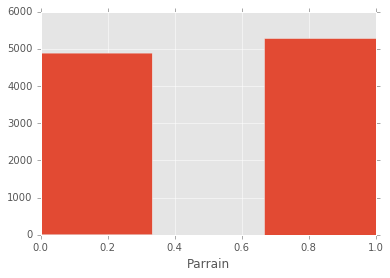

In [163]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
Parrain = df_merged.Parrain
plt.hist(Parrain, bins=3)
plt.xlabel('Parrain')
print("There are %s different values of concentrations." % np.unique(Parrain).size)

In [337]:
### Data management parrain
def data_management_parrain(df):
    
    ### Get flag parrain from id parrain
    df['Parrain'] = df['id_parain'].map(lambda x: 0 if pd.isnull(x) else 1).astype(int)
    del df['id_parain']
    
    ## Cathégoriser les parrains selon leur encours (0 ou 1)
    df['encours_p'] = pd.qcut(df['encours_parrain'].values, 2).codes
    del df['encours_parrain']
    
    ### USELESS COLUMNS
    
    del df['contactid']
    del df['sid_parrai']
    del df['id_parrain']
    del df['id_dim_personne'] 
    
    features_df = df.drop('cible', axis=1)
    target = df['cible']
    
    return features_df, target



In [338]:
X_parrain, y_parrain = data_management_parrain(df_merged)

In [339]:
X_parrain.head()

,campagne,code_postal,code_postal_naissance,country_connexion_name,csp,debit_cb,flag_banque_principale,flag_epargne,mailing_accord,nature_cb,patrimoine,pays_naissance,regime_matrimonial,revenus_annuels,AGE,domain,Sex,Parrain,encours_p
0,-1,nan,59430,France,15,nan,1,0,nan,nan,-1,FRA,2,2,nan,,-1,0,-1
1,456,31130,38000,France,2,0,0,0,0,1,2,FRA,4,2,47,yahoo.fr,1,1,1
2,868,92000,92150,France,2,nan,1,0,0,nan,2,FRA,2,4,59,free.fr,1,1,1
3,300,94800,93420,France,2,0,0,0,0,1,0,FRA,2,2,28,hotmail.fr,0,0,-1
4,300,26170,84600,Switzerland,2,nan,0,0,0,nan,0,FRA,0,2,23,gmail.com,1,1,0


In [401]:
X_parrain.head()

,campagne,code_postal,code_postal_naissance,country_connexion_name,csp,debit_cb,flag_banque_principale,flag_epargne,mailing_accord,nature_cb,patrimoine,pays_naissance,regime_matrimonial,revenus_annuels,AGE,domain,Sex,Parrain,encours_p
0,-1,69009,59430,2,15,0,1,0,0,1,-1,10,2,2,33,0,-1,0,-1
1,456,31130,38000,2,2,0,0,0,0,1,2,10,4,2,47,22,1,1,1
2,868,92000,92150,2,2,0,1,0,0,1,2,10,2,4,59,5,1,1,1
3,300,94800,93420,2,2,0,0,0,0,1,0,10,2,2,28,8,0,0,-1
4,300,26170,84600,7,2,0,0,0,0,1,0,10,0,2,23,6,1,1,0


In [402]:
export = X_parrain
export.to_csv("X_ext.csv", sep=',', encoding='utf-8')

In [350]:
# MLP
from sklearn.neural_network import MLPClassifier
clf2_mlp = MLPClassifier(hidden_layer_sizes=(11, 12), random_state=50)
clf2_mlp.fit(X02_train, y02_train)
yp_pred = clf2_mlp.predict(X02_test)

print(classification_report(y02_test, yp_pred))
print 'accuracy score : '+ str(accuracy_score(y02_test, yp_pred))
print '\n confussion matrix:\n',confusion_matrix(y02_test, yp_pred)

             precision    recall  f1-score   support

          0       0.81      0.69      0.75      5940
          1       0.22      0.36      0.27      1462

avg / total       0.70      0.62      0.65      7402

accuracy score : 0.622804647393

 confussion matrix:
[[4082 1858]
 [ 934  528]]


# Multiclass avec parrain

In [358]:
df_multi_p = pd.read_csv('df_new_initial.csv', sep=',')
del df_multi_p['Unnamed: 0']
del df_multi_p['Unnamed: 0.1']

In [359]:
df_parrain.head()

,id_dim_personne,id_parain
0,1004250808,224108008
1,1660202716,nan
2,1715100837,1697958997
3,1725735525,nan
4,1748840201,814632101


In [360]:
encours_p.head()

,encours_parrain,sid_parrai,id_parrain
0,15221,1976844,3310222733
1,9,1514352,2413380188
2,8403,2890682,5407353163
3,12150,3508176,6704932886
4,160,3310392,6186339895


In [361]:
### Data management
def data_management(df):
    get_age(df)
    
    ### USELESS COLUMNS
    del df['annee_mois']
    del df['id_dim_temps']
    del df['timestamp']
    del df['service']
    del df['campaign']
    del df['firstnamesponsor'] 
    del df['namesponsor'] 
    
    ### Get domain from mail
    df['mail'] = df.mail.replace ([np.nan], '')
    df['domain'] = df['mail'].map(lambda x: x.split("@")[1] if x else None)
    df['domain'] = df.domain.str.lower()
    del df['mail']

    ### Get Sex from Civility
    df['Sex'] = df['civilite'].map(get_sex)
    
    ### Del useless cols
    del df['civilite']
    del df['pays']
    
    ### transform to numeric when possible
    df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    df['country_connexion_name'] = df['country_connexion_name'].replace ([np.nan], '')
    df['domain'] = df['domain'].replace ([np.nan], '')
    df['pays_naissance'] = df['pays_naissance'].replace ([np.nan], '')
    df.loc[df['country_connexion_name'].value_counts()[df['country_connexion_name']].values < 40, 'country_connexion_name'] = 'other'
    df.loc[df['domain'].value_counts()[df['domain']].values < 40, 'domain'] = 'other'
    df.loc[df['pays_naissance'].value_counts()[df['pays_naissance']].values < 40, 'pays_naissance'] = 'other'

    ## Changer cible binaire 
    df['cible'] = pd.qcut(df['encours'].values, 5).codes
    del df['encours']

    return df



def get_sex(x):
    if x == "0":
        return 1
    elif (x == "1"):
        return 0
    elif (x == "2"):
        return 0
    elif (x == "MR"):
        return 1
    elif (x == "MLE"):
        return 0
    elif (x == "MME"):
        return 0
    else :
        return -1

def get_age(X):
    from datetime import datetime
    now = datetime.now()
    X['AGE'] = X['date_naissance'].dropna()
    X['AGE'] = pd.to_datetime(X['AGE'],errors='coerce')
    X['AGE'] = X['AGE'].map(lambda x : now.year-x.year  if now.month-x.month>0 else now.year - x.year -1 )
    del X['date_naissance']

In [362]:
dfm = data_management(df_multi_p)

In [363]:
dfm.head()

,contactid,campagne,code_postal,code_postal_naissance,country_connexion_name,csp,debit_cb,flag_banque_principale,flag_epargne,mailing_accord,nature_cb,patrimoine,pays_naissance,regime_matrimonial,revenus_annuels,id_dim_personne,cible,AGE,domain,Sex
0,6546762003,-1,nan,59430,France,15,nan,1,0,nan,nan,-1,FRA,2,2,6546762003,0,nan,,-1
1,6742433330,456,31130,38000,France,2,0,0,0,0,1,2,FRA,4,2,6742433330,0,47,yahoo.fr,1
2,6856828837,868,92000,92150,France,2,nan,1,0,0,nan,2,FRA,2,4,6856828837,4,59,free.fr,1
3,6754882186,300,94800,93420,France,2,0,0,0,0,1,0,FRA,2,2,6754882186,0,28,hotmail.fr,0
4,6289817192,300,26170,84600,Switzerland,2,nan,0,0,0,nan,0,FRA,0,2,6289817192,1,23,gmail.com,1


In [364]:
# Merger parrain id avec DF initial selon l'id client
enriched_multi_df = pd.merge(dfm,df_parrain, right_on='id_dim_personne', left_on='contactid')
enriched_multi_df.columns = ['contactid','campagne','code_postal','code_postal_naissance','country_connexion_name','csp','debit_cb','flag_banque_principale','flag_epargne','mailing_accord', 'nature_cb','patrimoine', 'pays_naissance','regime_matrimonial','revenus_annuels','id_dim_personne', 'cible' ,'AGE', 'domain','Sex', 'id_dim_personne','id_parain']
enriched_multi_df.head(10)

,contactid,campagne,code_postal,code_postal_naissance,country_connexion_name,csp,debit_cb,flag_banque_principale,flag_epargne,mailing_accord,...,pays_naissance,regime_matrimonial,revenus_annuels,id_dim_personne,cible,AGE,domain,Sex,id_dim_personne,id_parain
0,6546762003,-1,nan,59430,France,15,nan,1,0,nan,...,FRA,2,2,6546762003,0,nan,,-1,6546762003,nan
1,6742433330,456,31130,38000,France,2,0,0,0,0,...,FRA,4,2,6742433330,0,47,yahoo.fr,1,6742433330,5516969255
2,6856828837,868,92000,92150,France,2,nan,1,0,0,...,FRA,2,4,6856828837,4,59,free.fr,1,6856828837,6440631011
3,6754882186,300,94800,93420,France,2,0,0,0,0,...,FRA,2,2,6754882186,0,28,hotmail.fr,0,6754882186,nan
4,6289817192,300,26170,84600,Switzerland,2,nan,0,0,0,...,FRA,0,2,6289817192,1,23,gmail.com,1,6289817192,2989870176
5,6748699778,307,73150,92290,France,2,0,0,0,0,...,FRA,2,2,6748699778,0,54,hotmail.com,1,6748699778,nan
6,6856855432,307,75015,75015,France,18,nan,1,0,0,...,FRA,0,1,6856855432,1,24,gmail.com,1,6856855432,3084639000
7,6821231675,868,69001,69008,France,3,2,1,0,0,...,FRA,0,1,6821231675,4,27,gmail.com,0,6821231675,2306432202
8,6747566365,868,75015,42000,France,2,0,0,1,0,...,FRA,0,2,6747566365,2,28,gmail.com,0,6747566365,4942455827
9,6888675097,1543,59161,59300,France,12,nan,0,0,0,...,FRA,0,0,6888675097,2,20,gmail.com,0,6888675097,nan


In [367]:
# Merger enriched_df avec encours selon le id_parain 
dfm_merged = pd.merge(enriched_multi_df,encours_p, right_on='id_parrain', left_on='id_parain', how='left')

In [368]:
### Data management parrain
def data_management_parrain(df):
    
    ### Get flag parrain from id parrain
    df['Parrain'] = df['id_parain'].map(lambda x: 0 if pd.isnull(x) else 1).astype(int)
    del df['id_parain']
    
    ## Cathégoriser les parrains selon leur encours (0 ou 1)
    df['encours_p'] = pd.qcut(df['encours_parrain'].values, 2).codes
    del df['encours_parrain']
    
    ### USELESS COLUMNS
    
    del df['contactid']
    del df['sid_parrai']
    del df['id_parrain']
    del df['id_dim_personne'] 
    
    features_df = df.drop('cible', axis=1)
    target = df['cible']
    
    return features_df, target


In [369]:
Xm_parrain, ym_parrain = data_management_parrain(dfm_merged)

In [370]:
Xm_parrain

,campagne,code_postal,code_postal_naissance,country_connexion_name,csp,debit_cb,flag_banque_principale,flag_epargne,mailing_accord,nature_cb,patrimoine,pays_naissance,regime_matrimonial,revenus_annuels,AGE,domain,Sex,Parrain,encours_p
0,-1,nan,59430,France,15,nan,1,0,nan,nan,-1,FRA,2,2,nan,,-1,0,-1
1,456,31130,38000,France,2,0,0,0,0,1,2,FRA,4,2,47,yahoo.fr,1,1,1
2,868,92000,92150,France,2,nan,1,0,0,nan,2,FRA,2,4,59,free.fr,1,1,1
3,300,94800,93420,France,2,0,0,0,0,1,0,FRA,2,2,28,hotmail.fr,0,0,-1
4,300,26170,84600,Switzerland,2,nan,0,0,0,nan,0,FRA,0,2,23,gmail.com,1,1,0
5,307,73150,92290,France,2,0,0,0,0,1,3,FRA,2,2,54,hotmail.com,1,0,-1
6,307,75015,75015,France,18,nan,1,0,0,nan,0,FRA,0,1,24,gmail.com,1,1,1
7,868,69001,69008,France,3,2,1,0,0,0,0,FRA,0,1,27,gmail.com,0,1,1
8,868,75015,42000,France,2,0,0,1,0,1,0,FRA,0,2,28,gmail.com,0,1,0
9,1543,59161,59300,France,12,nan,0,0,0,nan,0,FRA,0,0,20,gmail.com,0,0,-1


In [371]:
X03_train,X03_test,y03_train,y03_test=train_test_split(Xm_parrain,ym_parrain,random_state=42)
X03_cat_features = Xm_parrain.loc[:, Xm_parrain.dtypes == object] 

### Encoding and inputation ###
encoder3 = EncodeCategorical(X03_cat_features.keys())
imputer3 = DataFrameImputer() 

### Encoder et inputer les set d'entrainement et de tests ###
X03_train = encoder.fit_transform(X03_train)
X03_train = imputer.fit_transform(X03_train)
X03_test = encoder.fit_transform(X03_test)
X03_test = imputer.fit_transform(X03_test) 

In [372]:
# MLP
from sklearn.neural_network import MLPClassifier
clf3_mlp = MLPClassifier(hidden_layer_sizes=(11, 12), random_state=50)
clf3_mlp.fit(X03_train, y03_train)
ymp_pred = clf3_mlp.predict(X03_test)

print(classification_report(y03_test, ymp_pred))
print 'accuracy score : '+ str(accuracy_score(y03_test, ymp_pred))
print '\n confussion matrix:\n',confusion_matrix(y03_test, ymp_pred)

             precision    recall  f1-score   support

          0       0.24      0.00      0.01      1503
          1       0.15      0.01      0.03      1445
          2       0.20      0.59      0.30      1516
          3       0.20      0.33      0.25      1473
          4       0.20      0.03      0.05      1465

avg / total       0.20      0.20      0.13      7402

accuracy score : 0.196568495001

 confussion matrix:
[[  4  29 884 534  52]
 [  3  21 950 438  33]
 [  4  29 902 539  42]
 [  3  28 920 486  36]
 [  3  30 935 455  42]]


# Proba

In [ ]:
u= cible
v="proba"
probabilite = "%s_%s" %(u,v)
predicted_target = "predicted_target_" + cible